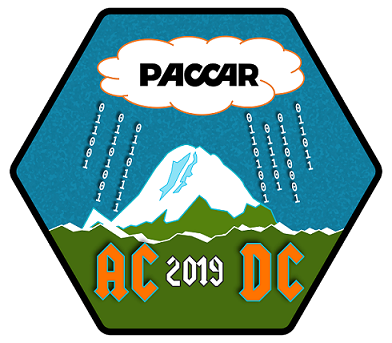
# Building a Predictive Model
***
This workshop is designed to give you the "gist" of how a predictive model can be built from historical data and why you might want to take this approach for a given problem. 

This workshop will use typical advanced analytics tools. However, it is focused on illustrating concepts, not teaching specific tools, machine learning algorithms, or tactics to maximize performance. I will provide a list of recommended resources for those who wish to go deeper and am happy to help with any questions you have. 

## Key Concepts
***
1. Business problems and predictive modeling solutions
2. Preparing data for modeling 
3. Finding informative features*
3. Building a baseline model and evaluating its performance
4. Iteratively improving a model

*Also known as variables

### 1. Business Problems and Predictive Modeling Solutions
***

The first step of predictive modeling is mapping a business problem to a predictive modeling approach that can solve the problem. To be useful, the technology must solve the right business problem. Here is a fictional scenario that we will use for illustration:

>The Seattle Police Department is undergoing a digital transformation initiative. The initiative aims to apply new technologies to improve services within the fixed resources allocated by the City Council. You are the first data scientist hired into a new predictive policing unit and are working through the long and tedious process of setting up your computer and obtaining access to the department's secure databases.

>Suddenly, the police chief arrives unannounced in your cubicle. The chief just got off the phone with the Mayor. The people of Seattle are protesting against the current level of car thefts, and local business owners are threatening to close their brick-and-morter store fronts if shoplifting rates continue at current levels. The mayor cannot provide additional resources but has directed the chief to "find a way" to address the issues. 

>You quickly confirm that the existing patrol assignments cannot be changed or increased. However, you learn that officers can conduct their existing patrols in ways that are more aggresive towards mitigating either car thefts or shoplifting. 

(Yes, this problem is contrived for the sake of giving a very clear modeling illustration. More interesting crime pairs can also work, but the problem gets more complicated).

**Q:** What is the business problem?

**Q:** What are potential predictive modeling solutions? 

**Q:** What data do we have? What assumptions/limitations apply to *historical*, *reported* crime data?

>With this insight, you propose using historical data to build a model that can predict whether a given patrol area at a given time is more likely to experience a car theft or shoplifting incident. You explain that the model can provide officers information for prioritization of car thefts vs. shoplifting in their patrols. 

>The chief likes your proposal, and asks you to come back with a prototype model and explaination for why the model should be trusted.

### 2. Preparing Data for Modeling
*** 
The second step is preparing data for modeling. Most of the time, predictive modeling requires a dataset formatted as follows:

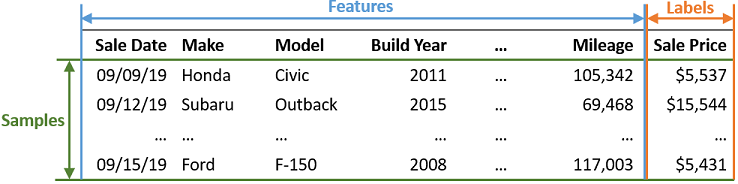

- **Features** are selected that might be relevant to the prediction being made. We generally start with everything that might be useful, and select or "engineer" the most informative features throughout the modeling process. 
- **Labels** are the values that we are trying to predict using the available features. 
- **Samples** are records that consist of features and a label. 

We begin by loading some standard packages (software add-ons) to the Python environment. The details of these packages are out of scope for this workshop, but basic descriptions are provided in the comments below.

In [ ]:
# Configuration for plotting in this notebook
%matplotlib inline

# General manipulation of tabular data and geographic data
import pandas as pd
import geopandas as gpd

#Numerical computing and linear algebra
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
import seaborn as sns

# Algorithms and helper functions for training and evaluating machine learning models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Standard package for programmatic access to your local filesystem (to be replaced with Snowflake) 
import os

# Constant variable for the filepath to your data
DATA_PATH = os.path.join('..', 'Data')

# This random seed ensures reproducibility of the modeling
RANDOM_SEED = 15

In [ ]:
# Sometimes have to re-run this in a second cell
matplotlib.rcParams.update({'font.size': 15})

Next, let's load in the modeling dataset which has been prepared from the data used in earlier workshops. Sometimes we will have to perform data preparation in Python using the pandas package. In this case, we have already prepared the data for you. We have included all reported car theft and shoplifting events starting in 2018.

#### 2.1 Previewing the data

In [ ]:
# Load data from a prepared .csv file
df = pd.read_csv('modeling_data.csv', parse_dates=['occurred_datetime', 'reported_datetime'])
df.head() # Look at the first five rows of data

Notice that the dataset is in a similar format to the used car example described above:
- Each **sample** is a reported crime event.
- "crime_subcategory" is the **label**, and can either be "theft-shoplift" or "motor_vehicle_theft"
- All other columns are the raw **features**. 

Our objective is to use the features to predict the crime-type label. A model of this format would allow an officer to input their next patrol time and location and receive a prediction of the more likely crime type. 

#### 2.2 Holding some data out

After the dataset is in the correct format to begin modeling, we need to split the dataset and "hold out" a portion for evaluating our models. We use the majority of the historical data to train a model, and then we use the "held out" data to estimate how well we expect the model to work when predicting the labels for new, unseen records. 

**Q:** What problems might we run into if we use the same data to build and then test a predictive model?

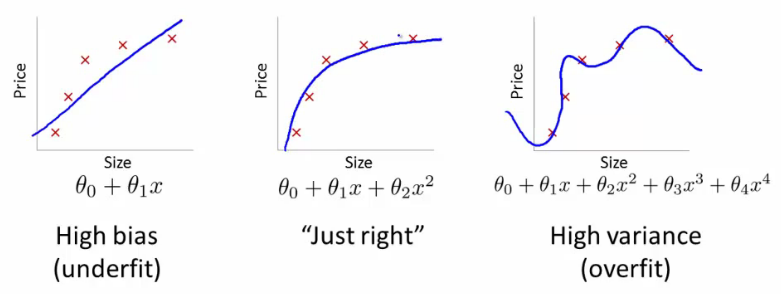
<center> <strong> Overfitting - Why We Hold Data Out </strong> <br> Source: Andrew Ng's ML course - https://www.coursera.org/learn/machine-learning</center>

 <br>
<strong> Important - Overfitting </strong> <br>
The avoidance of overfitting is a fundamental aspect of any predictive modeling problem. We seek to learn meaningful patterns that will *generalize* to new samples, as opposed to simply *memorizing* a historical dataset.


**Q:** Which records should we choose to hold out?

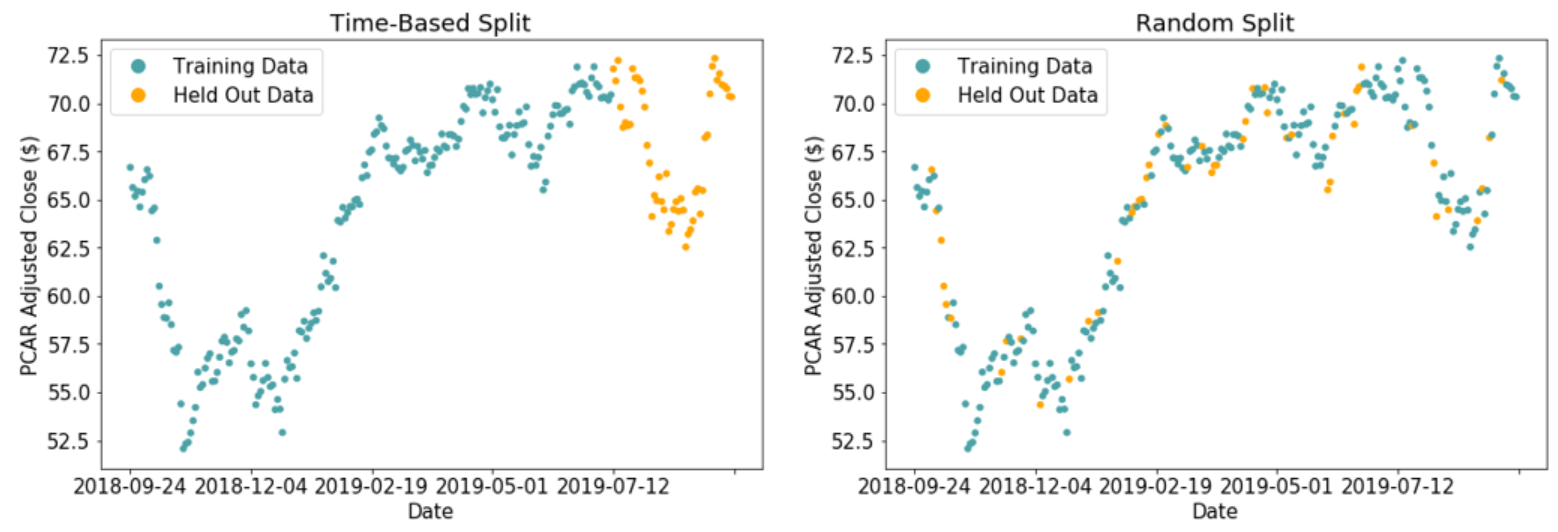
<center> <strong> Daily Adjusted Close of PCAR with Different Data Held Out </strong> </center>

We will sort the records by date and use the first (oldest) 90% for training a model and last (most recent) 10% for evaluating the model. While this is not strictly a time series problem, the distribution of crime in a given week is likely related to the distribution in the prior and following week. Often an 80/20 split is used for non-time-based problems, as shown below. 

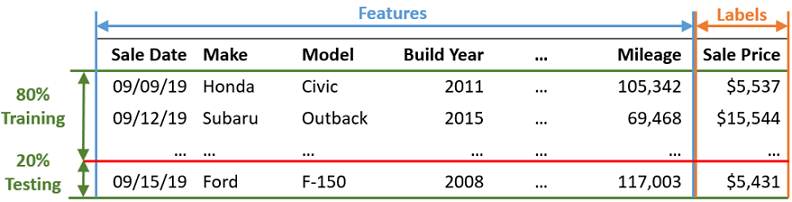
<center> <strong> An Illustration of Time-Based Splitting </strong> </center>

In [ ]:
# Sort the entire dataset by date and time
df.sort_values('occurred_datetime', inplace=True)

# Store the indices of the samples that correspond to the first 80% (train) and last 20% (test)
# We will use these later whenever we need to access only the train or test portion of the dataset
train_idx = np.arange(int(0.8*df.shape[0]))
test_idx = np.arange(int(0.8*df.shape[0]), df.shape[0])
print(f"First training data date: {df.iloc[train_idx]['occurred_datetime'].dt.date.min()}")
print(f"Last training data date: {df.iloc[train_idx]['occurred_datetime'].dt.date.max()}")
print(f"Last testing data date: {df.iloc[test_idx]['occurred_datetime'].dt.date.max()}")

### 3. Finding informative features
***
The next step of predictive modeling is similar to any type of prediction, understanding what information you have and whether it is informative of the event or value that you need to predict. In general, we have two primary types of features for each incident:

1. *When* the event happened
2. *Where* the event happened (this includes attributes of the location where the event happend)

We also have data about the weather when the event happened. 

 <br>
<strong> Important - Using Available Data </strong> <br>
When making predictions, we can only use information that will be available when the model is used. In this case, we know the time and location of a future patrol and can use these features. However, if the dataset included a feature for total number of crimes reported per beat on the day of the event, we would not be able to use it for this application. 


#### 3.1 Exploring crime type vs. when event occurs

In [ ]:
# Extract year, month, day of week, and hour of day from the date and time of occurence
# This creates new columns that only contain these specific variables
df['year'] = df['occurred_datetime'].dt.year
df['month'] = df['occurred_datetime'].dt.month
df['dayofweek'] = df['occurred_datetime'].dt.dayofweek
df['hour'] = df['occurred_datetime'].dt.hour

# Plot counts of each crime category vs. year
pd.crosstab(df.iloc[train_idx]['year'], df.iloc[train_idx]['crime_subcategory'])

The proportionality of car theft and shoplifting seems fairly consistent over time. It might be higher in 2019, but that could also be biased by the small number of samples and limited subset of the year being measured (only January).

In [ ]:
# Look at type of crime vs. month
grp_month_category = df.iloc[train_idx].groupby(['month', 'crime_subcategory'], as_index=False).agg({'report_number':len})
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(x='month', y='report_number', hue='crime_subcategory', data=grp_month_category, ax=ax)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

Proportionally, shoplifting appears to be much more prevalant in the winter compared to the summer. The January counts are higher because they include 3 years of data. 

In [ ]:
# Look at type of crime vs. day of the week
grp_day_category = df.iloc[train_idx].groupby(['dayofweek', 'crime_subcategory'], as_index=False).agg({'report_number':len})
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(x='dayofweek', y='report_number', hue='crime_subcategory', data=grp_day_category, ax=ax)
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

It appears that car theft may be more prevalent on Friday and Saturday then on other days. 

In [ ]:
# Look at type of crime vs. hour of the day
grp_hour_category = df.iloc[train_idx].groupby(['hour', 'crime_subcategory'], as_index=False).agg({'report_number':len})
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(x='hour', y='report_number', hue='crime_subcategory', data=grp_hour_category, ax=ax)
ax.set_xticklabels(['12a', '1a', '2a', '3a', '4a', '5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p',
                    '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p', '11p'])
plt.show()

The relationship between time and the type of crime is very striking. Shoplifting is more prevalent during business hours (roughly 9am-8pm) while car theft is more prevalent outside of business hours. Hour of day is likely to be an informative feature for prediction. 

In [ ]:
# Let's look at proportion of shoplifting vs. day of week and hour of day
df['shoplifting'] = (df['crime_subcategory'] == 'theft-shoplift').astype(int)
grp_day_hour = df.iloc[train_idx].groupby(['dayofweek', 'hour']).agg({'shoplifting':np.mean}).unstack('hour')
grp_day_hour.columns = grp_day_hour.columns.get_level_values(1)
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(grp_day_hour, ax=ax, cmap='coolwarm', vmin=0, vmax=1.0)
ax.set_xticklabels(['12a', '1a', '2a', '3a', '4a', '5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p',
                    '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p', '11p'])
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_title('Proportion Shoplifting Events by Hour and Day (Red = More Shoplifting)')
plt.show()

There may be some patterns between day of week and hour of day, but they are not obvious by manual inspection. 

#### 3.2 Exploring crime type vs. where event occurs

In [ ]:
# Load in shape files for the various crime beats
bg_df = gpd.read_file('Seattle_Police_Beats_2018Present.shp')
bg_df = bg_df.to_crs({'init': 'epsg:4326'})
bg_df.columns = [col.lower().replace(' ', '_') for col in bg_df.columns]

grp_df = pd.get_dummies(df, columns=['crime_subcategory'], prefix='', prefix_sep='').iloc[train_idx].groupby('beat').agg({'motor_vehicle_theft':[np.sum, np.mean],
                                                                                                                          'theft-shoplift':[np.sum, np.mean]})
grp_df.columns = ['num_motor_vehicle_theft', 'perc_motor_vehicle_theft', 'num_theft-shoplift', 'perc_theft-shoplift']

# Group counts of each crime category by Beat and join with the beat geometries
bg_df = bg_df.join(grp_df, on='beat')

In [ ]:
# Plot counts of crime in each category
fig, ax = plt.subplots(1,2, figsize=(16,6))
categories = ['motor_vehicle_theft', 'theft-shoplift']
for i, category in enumerate(categories):
    bg_df.dropna().plot(column=f'num_{category}', ax=ax[i], legend=True)
    ax[i].set_title(f"'17-'19 {category} crime counts")
    ax[i].scatter([-122.3259, -122.2983, -122.3374], [47.7059, 47.6632, 47.6120], c='r')
fig.tight_layout()
plt.show()

The red dots indicate the locations of three major Seattle shopping malls. As expected, the corresponding beats have a higher prevalence of shoplifting. 

As we explore the information that the features provide about the labels, we might think of ways we want to transform the existing features into new features that more clearly reveal patterns with the labels. For example, I can represent the location of each crime using the latitude and longitude of the beat they occurred in, as well as the distance from the center of the downtown core. 

In [ ]:
# Extract lat and lon
bg_df['lat'] = bg_df['geometry'].centroid.y
bg_df['lon'] = bg_df['geometry'].centroid.x

# Make a set of pairplots
matplotlib.rcParams.update({'font.size': 14})
sns.pairplot(bg_df.dropna().loc[:,['lat', 'lon', 'perc_theft-shoplift']], height=2.8)
plt.show()

There may be some relationships, although they are not very clear. Let's try using demographic features.

In [ ]:
# Join demographic features to the beats dataframe and evaluate relationships
feats = ['perc_lt_hs_grad', 'median_income', 'perc_below_poverty', 'log_pop_density_sq_m']
mbg_df = bg_df.merge(df.loc[:,['beat'] + feats], how='left', on='beat')
sns.pairplot(mbg_df.dropna().loc[:,feats + ['perc_theft-shoplift']])
fig.tight_layout()
plt.show()

Shoplifting appears to be more prevalent in areas with higher population density, while car theft may be more prevalent in areas with lower high school graduation rate. There are also some outliers in some of the features. Typically, we would spend more time on exploring the various features and deciding how to handle outliers. However, that level of detail is beyond the scope of this workshop. 

### 4. Training a baseline model and evaluating its performance
***

#### 4.1 From observed patterns to decision rules

We have found some features that appear to be informative (e.g. time of day, whether a shopping mall is located within the beat, education level statistics of the beat, etc.). We could try to study each feature and compile a list or rules like:

- "Between 9am and 8pm, assume shoplifting is more likely"
- "If a shopping mall is located within the beat, assume shoplifting is more likely"
- "If the population density is below X, assume car theft is more likely"

However, there are two limitations of this approach. First, how do we select all of these rules by hand? We may catch the obvious ones, but we might miss more subtle rules or define the rules in suboptimal ways (e.g. what should X be in the third rule?). Second, how do we account for the interaction of all of these rules?

For example, what would the above rules predict for a patrol from 6-8 am, in a beat with a shopping mall, with a low population density? 

This is where various machine learning algorithms can help us - by learning a model (i.e. a set of prediction rules) that would be impossible or impractical to build by hand. 

#### 4.2 Building a baseline decision tree model

It's finally time to build a baseline model and see how it does on held-out test data. However, we also want a reference point to evaluate the benefit of the model compared to a reasonable alternative. In this case, I will compare the model to two alternative approaches for the prediction:
1. Always predict the more common crime type (shoplifting in this case)
2. Using the plots from the previous section, predict the crime type that is more common for each hour of the day


<strong> Important - Considering a Reasonable Baseline </strong> <br>

Predictive models are sometimes "sold" by showing their superiority to random guessing. This assumes that the alternative to a predictive model is random guessing, which is almost always not the case. The strongest available non-modeling alternative should be used to measure the value of a predictive model. These alternatives can come from data exploration or knowledge of domain experts.



To start, I will use a simple machine learning model known as a decision tree. The algorithm works as follows:

1. Scan over all features and see which feature best separates the two crime types. 
2. Split the training data using the best features.
3. Now, using the split datasets, repeat steps 1 and 2 for each sub-dataset.

This process continues until the desired number of rules or other criteria is met. Now, we will build a simple decision tree model using our training set, and compare it to the alternative baselines on the testing set. To begin, we will only let the model use one feature - hour of the day.

In [ ]:
# Train a model and make predictions for the model as well as both baselines
# Baseline (1): majority classifier
# Baseline (2): business hours = shoplifting

# Select model features from the dataset 
predictive_features = ['hour']

# This creates a new feature for every single beat - each feature is either 0 (false) or 1 (true) and each
# event only has a 1 in the column for the beat that corresponds to that event. 
#train_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat']).iloc[train_idx]
train_X_df = df.loc[:,predictive_features].iloc[train_idx]
train_y = df.iloc[train_idx]['shoplifting']

#test_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat']).iloc[test_idx]
test_X_df = df.loc[:,predictive_features].iloc[test_idx]
test_y = df.iloc[test_idx]['shoplifting']

decision_tree = DecisionTreeClassifier(max_depth=2)
decision_tree.fit(train_X_df.values, train_y.values)

train_preds = decision_tree.predict(train_X_df)
test_preds = decision_tree.predict(test_X_df)

train_b1_preds = np.ones(train_y.shape[0]) * np.argmax(np.bincount(train_y.values))
# Feel free to modify the hours below if you think you can make a better manual time of day rule
train_b2_preds = ((train_X_df['hour'] >= 9) & (train_X_df['hour'] <= 20)).astype(int)

test_b1_preds = np.ones(test_y.shape[0]) * np.argmax(np.bincount(train_y.values))
# Feel free to modify the hours below if you think you can make a better manual time of day rule
test_b2_preds = ((test_X_df['hour'] >= 9) & (test_X_df['hour'] <= 20)).astype(int)

# Compute training set accuracies
b1_train_acc = accuracy_score(train_y.values, train_b1_preds)
b2_train_acc = accuracy_score(train_y.values, train_b2_preds)
rf_train_acc = accuracy_score(train_y.values, train_preds)

# Compute test set accuracies
b1_test_acc = accuracy_score(test_y.values, test_b1_preds)
b2_test_acc = accuracy_score(test_y.values, test_b2_preds)
rf_test_acc = accuracy_score(test_y.values, test_preds)

print(f'Training Set Accuracies: Majority = {b1_train_acc:.3f}, Business Hours = {b2_train_acc:.3f}, Decision Tree = {rf_train_acc:.3f}')
print(f'Testing Set Accuracies: Majority = {b1_test_acc:.3f}, Business Hours = {b2_test_acc:.3f}, Decision Tree = {rf_test_acc:.3f}')

The printout above shows the accuracy of the "majority" crime baseline, the "business hours" baseline, and the trained decision tree model. Accuracy is probably the simplest and most common performance metric for a classification model and is simply the proportion of labels that the model predicted correctly. 

Interesting, the decision tree is almost identical in performance to our manually selected decision rules. Let's see what the tree learned.

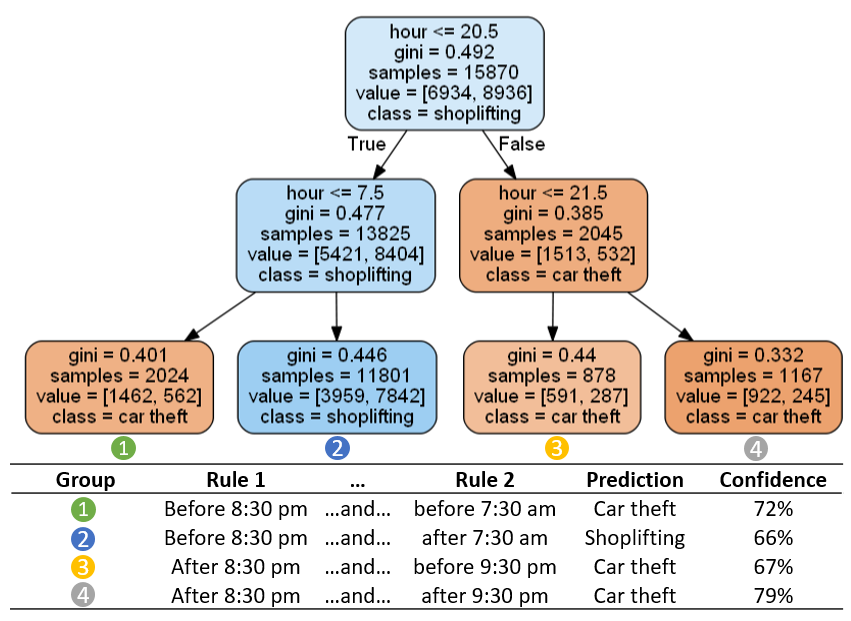
<center> <strong> The Rules in the Simple Decision Tree </strong> </center>

#### 4.3 Building a baseline random forest model

The single-figure decision tree makes for a clear illustration but is not doing any better than our manually selected prediction rule. However, the advantage of machine learning is the ability to consider many features at once to learn complex rule-sets that would be impracticable to define by hand. 

For a real baseline model, I will use a popular algorithm called Random Forest. The details of how it works are beyond the scope of this workshop, but the intuition is:

- The algorithm looks at the training portion of the dataset and automatically builds hundreds or thousands of decision trees.
- Each tree only uses a subset of the dataset and subset of the features (randomly selected). This encourages the model to learn meaningful patterns as opposed to simply memorizing specific training samples. 
- Each of the trees has a different "perspective" on the dataset. When we make predictions, each of the trees get a "vote" and the collective votes of the entire "forest" of trees determine the overall prediction of the model.

It's kind of like asking a bunch of friends what movies are the best and then watching whatever movies came up most consistently. Your friends all have some difference in preferences and in the movies they have seen. However, the most common recommendations are likely to generalize well to new people, including you. 

In [ ]:
# Train a model and make predictions for the model as well as both baselines
# Baseline (1): majority classifier
# Baseline (2): business hours = shoplifting

# Select predictive features
predictive_features = ['beat', 'year', 'month', 'dayofweek', 'hour', 'lat', 'lon']

# This creates a new feature for every single beat - each feature is either 0 (false) or 1 (true) and each
# event only has a 1 in the column for the beat that corresponds to that event. 
train_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat']).iloc[train_idx]
train_y = df.iloc[train_idx]['shoplifting']

test_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat']).iloc[test_idx]
test_y = df.iloc[test_idx]['shoplifting']

random_forest = RandomForestClassifier(n_estimators=1000, min_samples_leaf=10, random_state=RANDOM_SEED)
random_forest.fit(train_X_df.values, train_y.values)

train_preds = random_forest.predict(train_X_df)
test_preds = random_forest.predict(test_X_df)
test_scores = random_forest.predict_proba(test_X_df)[:,1]

train_b1_preds = np.ones(train_y.shape[0]) * np.argmax(np.bincount(train_y.values))
# Feel free to modify the hours below if you think you can make a better manual time of day rule
train_b2_preds = ((train_X_df['hour'] >= 9) & (train_X_df['hour'] <= 20)).astype(int)

test_b1_preds = np.ones(test_y.shape[0]) * np.argmax(np.bincount(train_y.values))
# Feel free to modify the hours below if you think you can make a better manual time of day rule
test_b2_preds = ((test_X_df['hour'] >= 9) & (test_X_df['hour'] <= 20)).astype(int)

# Compute training set accuracies
b1_train_acc = accuracy_score(train_y.values, train_b1_preds)
b2_train_acc = accuracy_score(train_y.values, train_b2_preds)
rf_train_acc = accuracy_score(train_y.values, train_preds)

# Compute test set accuracies
b1_test_acc = accuracy_score(test_y.values, test_b1_preds)
b2_test_acc = accuracy_score(test_y.values, test_b2_preds)
rf_test_acc = accuracy_score(test_y.values, test_preds)

print(f'Training Set Accuracies: Majority = {b1_train_acc:.3f}, Business Hours = {b2_train_acc:.3f}, Random Forest = {rf_train_acc:.3f}')
print(f'Testing Set Accuracies: Majority = {b1_test_acc:.3f}, Business Hours = {b2_test_acc:.3f}, Random Forest = {rf_test_acc:.3f}')

The accuracy is presented for both the training set and the held-out testing set. The random forest scores 82% on the training set, but scores only 76% on the held-out test set. 76% is still better than both baseline approaches, but the 82% training accuracy illustrates why it is crucial to properly evaluate a model on held-out data.

#### 4.4 Are some errors more costly than others?

Sometimes we care more about some types of errors than others. For example, with an inexpensive disease screening, it might be ok to have many false alarms so long as the vast majority of real issues are uncovered. However, we are filtering spam email, we'd probably rather delete a few peices of spam each week than miss a single peice of important, real correspondance. A "confusion matrix" is a popular way of visualizing this trade-off. 

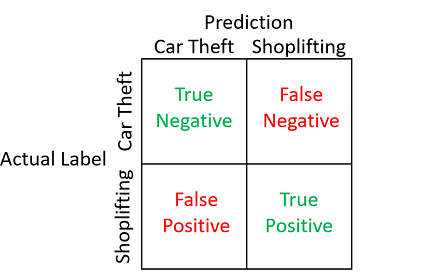
<center> <strong> A "Confusion Matrix" </strong> </center>

Let's look at the confusion matrices for the two baselines as well as the random forest model.

In [ ]:
# Plot confusion matrices
fig, ax = plt.subplots(1,3, figsize=(14,4))
sns.heatmap(confusion_matrix(test_y.values, test_b1_preds), ax=ax[0], annot=True, cmap='Blues', fmt='d', xticklabels=['car theft', 'shoplift'], yticklabels=['car theft', 'shoplift'])
ax[0].set_title(f'Majority Baseline \n Accuracy = {int(100*b1_test_acc)}%')
sns.heatmap(confusion_matrix(test_y.values, test_b2_preds), ax=ax[1], annot=True, cmap='Blues', fmt='d', xticklabels=['car theft', 'shoplift'], yticklabels=['car theft', 'shoplift'])
ax[1].set_title(f'Business Hours Baseline \n Accuracy = {int(100*b2_test_acc)}%')
sns.heatmap(confusion_matrix(test_y.values, test_preds), ax=ax[2], label=f'Random Forest', annot=True, cmap='Blues', fmt='d', xticklabels=['car theft', 'shoplift'], yticklabels=['car theft', 'shoplift'])
ax[2].set_title(f'Random Forest \n Accuracy = {int(100*rf_test_acc)}%')
for i in range(3):
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Actual')
fig.tight_layout()
plt.show()

While assuming the most common event results in (barely) majority correct results, that baseline gets 100% of the car theft events incorrect. Similarly, the business hours baseline does well on predicting shoplifting, but misses about half of the car theft events caught by the random forest model. 

**Q:** What are some business situations where we might be more concerned about different types of errors?

#### 4.4 Learning from extreme examples

We can often get additional insight into what a predictive model has learned by reviewing extreme examples where the model was very confident in a prediction and either wrong or right. Under the hood, the model actually predicts a probability (from 0 to 1) of shoplifting. We have been considering anything greater than 0.5 to be a shoplifting event. 

First, let's review examples where the model confidently predicted shoplifting and was correct. 

In [ ]:
test_df = df.iloc[test_idx].copy()
test_df['probability_shoplift'] = test_scores
test_df.sort_values('probability_shoplift', ascending=False, inplace=True)
test_df = test_df.loc[:,['probability_shoplift', 'crime_subcategory'] + predictive_features]
test_df.loc[test_df['crime_subcategory'] == 'theft-shoplift'].head()

These events are all within a few "downtown core" beats and between 1 and 4 pm and on Saturday or Sunday. 

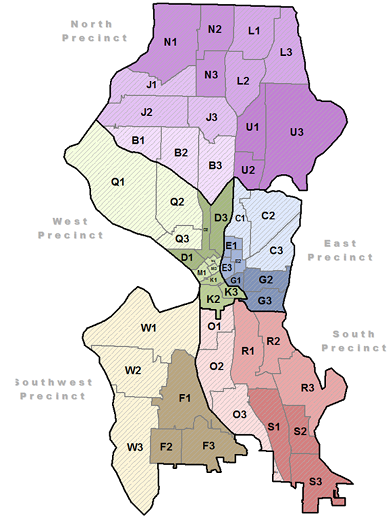
<center> <strong> Seattle Police Beats </strong> <br> credit: https://www.seattle.gov/police/information-and-data/tweets-by-beat</center>

Next, let's look at examples where the model confidently predicted shoplifting and was wrong.

In [ ]:
test_df.loc[test_df['crime_subcategory'] == 'motor_vehicle_theft'].head()

Notice that the attributes are almost the same as the correct predictions. The model doesn't seem to have much information to differentiate. 

In [ ]:
# Let's look at examples where the model was most confident of car theft and correct
test_df.sort_values('probability_shoplift', ascending=True, inplace=True)
test_df = test_df.loc[:,['probability_shoplift', 'crime_subcategory'] + predictive_features]
test_df.loc[test_df['crime_subcategory'] == 'motor_vehicle_theft'].head()

These events are farther from the downtown core, although they occur later in the afternoon or early in the morning.

In [ ]:
# Let's look at examples where the model was most confident of car theft and incorrect
test_df.loc[test_df['crime_subcategory'] == 'theft-shoplift'].head()

A few of these happened at very unusual times for shoplifting, and the locations are outside the downtown core.

#### 4.5 What does the model think is important?

We can also directly interrogate the trained model and get a rank of the relative importance of features in the rules that were learned. The exact method for this ranking is beyond the scope of this workshop, but at a high level, the rank is based on which features are used most often and most successfully to separate the labels in the training set. 

In [ ]:
# Look at feature importances from trained model
pd.Series(index=train_X_df.columns, data=random_forest.feature_importances_).sort_values().iloc[-20:].plot(kind='barh', figsize=(6,6))
plt.title('Relative Importance of Top 20 Features')
plt.show()

Careful study of the incorrect predictions, feature importance plot, and exploratory analysis above can provide some clues as to what the model has and has not learned. These clues can be helpful in improving the model in future iterations. 

### 5. Iteratively Improving a Model 
***
Predictive modeling is an iterative process. It is important to quickly develop a baseline model and gain an understanding of whether the dataset appears to have any informative features that can be exploited. Beyond that, many levers can be applied to improve the model:

- Other algorithms can be tried, or even combined, with the baseline model
- There are ways to fine tune a model to a given dataset
- Sometimes, more data can be collected in an attempt to provide more information
- Additional features can be added or "engineered" (derived) from existing features, non-informative features can be removed

An exhaustive demo of these different levers is beyond the scope of this workshop. However, I will demonstrate a simple example of adding and "engineering" new features. In my experience, this is often one of the most fruitful approaches and is also an area where domain expert knowledge can be a great complement to automatic machine learning algorithms. 


<strong> Important - Leveraging Domain Expertise </strong> <br>

It is true that machine learning adds value by uncovering patterns that are difficult to manually derive. However, domain expertise is essential to select relevant data and engineer effective features to build predictive models. Machine learning is mostly an augmentation of domain knowledge and rarely a substitute. If this was a real assignment, you would certainly want to interview police officers and ask them what factors correlate with each of these crimes.  



In [ ]:
# Add a feature for "beat has a mall"
has_mall = ['U3', 'L2', 'M1', 'M2', 'M3']
df['has_mall'] = df['beat'].isin(has_mall)

# Form a feature for distance from downtown core
df['dist2core'] = np.sqrt(np.power(df['lat'] - 47.6015,2) + np.power(df['lon'] + 122.3343,2))

In [ ]:
# Potential features if you'd like to try experimenting on your own - add and subtract from this list to the 
# "predictive features" below
# ['report_number', 'crime_subcategory', 'primary_offense_description',
#  'precinct', 'sector', 'beat', 'neighborhood', 'population', 'median_age',
#  'perc_lt_hs_grad', 'perc_grad_prof_df', 'median_income',
#  'perc_below_poverty', 'pop_density_sq_meter', 'log_pop_density_sq_m',
#  'lat', 'lon', 'area_sq_meters', 'avg_temp', 'high_temp', 'min_temp',
#  'prcp', 'fog', 'heavy_fog', 'smoke', 'year', 'month', 'dayofweek',
#  'hour', 'shoplifting', 'has_mall', 'dist2core']

# Select predictive features for new "beat has a mall", beat demographic attributes, and neighborhood features
predictive_features = ['beat', 'year', 'month', 'dayofweek', 'hour', 'lat', 'lon', 'dist2core',
                       'median_age', 'perc_lt_hs_grad', 'perc_grad_prof_df',
                       'median_income', 'perc_below_poverty', 'pop_density_sq_meter', 'has_mall',
                       'neighborhood']

train_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat', 'neighborhood']).iloc[train_idx]
train_y = df.iloc[train_idx]['shoplifting']

test_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat', 'neighborhood']).iloc[test_idx]
test_y = df.iloc[test_idx]['shoplifting']

# Train a model and make predictions to compare to two baselines
# Baseline (1): majority classifier
# Baseline (2): business hours = shoplifting

random_forest = RandomForestClassifier(n_estimators=1000, min_samples_leaf=10, random_state=RANDOM_SEED)
random_forest.fit(train_X_df.values, train_y.values)

train_preds = random_forest.predict(train_X_df)
test_preds = random_forest.predict(test_X_df)

train_b1_preds = np.ones(train_y.shape[0]) * np.argmax(np.bincount(train_y.values))
train_b2_preds = ((train_X_df['hour'] >= 9) & (train_X_df['hour'] <= 20)).astype(int)

test_b1_preds = np.ones(test_y.shape[0]) * np.argmax(np.bincount(train_y.values))
test_b2_preds = ((test_X_df['hour'] >= 9) & (test_X_df['hour'] <= 20)).astype(int)

# Compute training set accuracies
b1_train_acc = accuracy_score(train_y.values, train_b1_preds)
b2_train_acc = accuracy_score(train_y.values, train_b2_preds)
rf_train_acc = accuracy_score(train_y.values, train_preds)

# Compute test set accuracies
b1_test_acc = accuracy_score(test_y.values, test_b1_preds)
b2_test_acc = accuracy_score(test_y.values, test_b2_preds)
rf_test_acc = accuracy_score(test_y.values, test_preds)

print(f'Training Set Accuracies: Majority = {b1_train_acc:.3f}, Business Hours = {b2_train_acc:.3f}, Random Forest = {rf_train_acc:.3f}')
print(f'Testing Set Accuracies: Majority = {b1_test_acc:.3f}, Business Hours = {b2_test_acc:.3f}, Random Forest = {rf_test_acc:.3f}')

The accuracy has changed from about 75.7% to about 76.0%. This is small enough that the difference is meaningless. Sometimes, features that seem like a good idea do not provide any additional performance. This is why we have to carefully consider how we incorporate evaluation into the modeling process.


<strong> Important - Don't Overfit to the Test Data </strong> <br>

For simplicity, I have only split the dataset into training and testing portions. In a typical iterative modeling workflow, a third portion of data is also held out and is not used until after the final iteration of model improvements. Otherwise, we might simply try more modeling approaches until a model "happens" to score well based on random chance. 



In [ ]:
# Look at feature importances from final trained model
pd.Series(index=train_X_df.columns, data=random_forest.feature_importances_).sort_values().iloc[-20:].plot(kind='barh', figsize=(6,6))
plt.title('Relative Importance of Top 20 Features')
plt.show()

## What Have We Learned?
***
1. Business problems and predictive modeling solutions
2. Preparing data for modeling 
3. Finding informative features
3. Building a baseline model and evaluating its performance
4. Iteratively improving a model

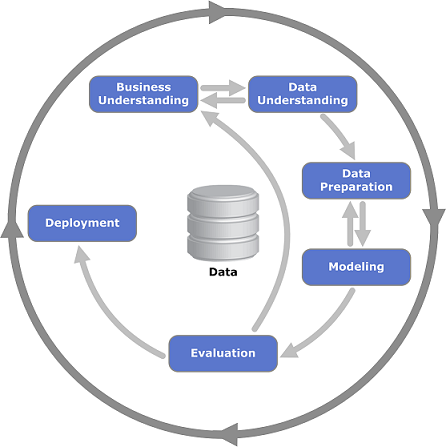
<center> <strong> CRISP-DM Process Diagram </strong> <br> credit: https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining#/media/File:CRISP-DM_Process_Diagram.png </center>

### Retrospective Questions
***
**Q:** What kind of data do I need to pursue a predictive modeling solution? <br>
**Q:** How is a machine learning approach the same or different from manual data analysis? <br>
**Q:** How does domain expert knowledge relate to machine learning? <br>
**Q:** What are some methodological pitfalls to watch out for if I am building or using a machine learning solution? <br>

### Resources for Further Study
***
| I... | Recommended Resource | 
| --- | --- | 
| ...prefer less math and want a business-impact oriented introduction to data science | https://www.goodreads.com/book/show/17912916-data-science-for-business?from_search=true <br> https://www.edx.org/course/the-analytics-edge-2 |
| ...prefer less math and want to have more understanding of statistics | https://www.goodreads.com/book/show/17986418-naked-statistics?from_search=true |
| ...want to learn how to program in general | https://www.edx.org/course/6-00-1x-introduction-to-computer-science-and-programming-using-python-3 | 
| ...want to learn how to work with data in Python, Jupyter Notebooks, etc. | https://www.goodreads.com/book/show/14744694-python-for-data-analysis?from_search=true|
| ...am comfortable with basic statistics want to get started with machine learning from a more conceptual approach | https://www.goodreads.com/book/show/17397466-an-introduction-to-statistical-learning?from_search=true <br>https://www.coursera.org/learn/machine-learning|
| ...am comfortable with basic statistics and linear algebra, and I want to get started with machine learning from a more hands-on approach |  https://www.goodreads.com/book/show/32899495-hands-on-machine-learning-with-scikit-learn-and-tensorflow?ac=1&from_search=true |
| ...am comfortable with advanced math and want to really understand machine learning at a more theoretical level | https://www.goodreads.com/book/show/148009.The_Elements_of_Statistical_Learning?from_search=true <br> https://www.goodreads.com/book/show/213030.Machine_Learning |



### Appendix A: Prediction Thresholds

Under the hood, the model is actually predicting the probability that each sample is a shoplifting or car theft event. We are using a probability of 0.5 as the decision threshold, but any threshold between 0 and1.0 can be used depending on which errors are more costly. 

In [ ]:
# Save probabilities instead of binary predictions
test_scores = random_forest.predict_proba(test_X_df)[:,1]

# Select a threshold
#******************************************************************************
threshold = 0.8
#******************************************************************************

# Compute accuracy at the selected threshold
rf_thresh_acc = accuracy_score(test_y.values, test_scores > threshold)

# Plot the distribution of "probabilities" for each true label
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(14,6))
ax.hist(test_scores[test_y.values == 1], label='Actual Shoplifting Events', alpha=0.5, bins=np.linspace(0,1,25))
ax.hist(test_scores[test_y.values == 0], label='Actual Car Theft Events', alpha=0.5, bins=np.linspace(0,1,25))
ax.set_xlabel('Predicted Probability of Shoplifting')
ax.set_ylabel('Counts per Bin')
ax.set_xticks(np.linspace(0,1,15))
ax.set_title('Probability of Shoplifting vs. Actual Label')
ax.axvline(threshold, color='r', label=f'p={threshold} Decision Threshold, Acc={int(100*rf_thresh_acc)}%')
if threshold != 0.5:
    ax.axvline(0.5, color='r', label=f'p=0.5 Decision Threshold, Acc={int(100*rf_test_acc)}%', linestyle='--')
ax.legend(loc='upper left')
plt.show()

In [ ]:
# Plot confusion matrices with different thresholds
fig, ax = plt.subplots(1,3, figsize=(14,4))
sns.heatmap(confusion_matrix(test_y.values, test_b1_preds), ax=ax[0], annot=True, cmap='Blues', fmt='d', xticklabels=['car theft', 'shoplift'], yticklabels=['car theft', 'shoplift'])
ax[0].set_title(f'Majority Baseline \n Accuracy = {int(100*b1_test_acc)}%')
sns.heatmap(confusion_matrix(test_y.values, test_scores > 0.5), ax=ax[1], annot=True, cmap='Blues', fmt='d', xticklabels=['car theft', 'shoplift'], yticklabels=['car theft', 'shoplift'])
ax[1].set_title(f'Random Forest, p=0.5 \n Accuracy = {int(100*rf_test_acc)}%')
sns.heatmap(confusion_matrix(test_y.values, test_scores > threshold), ax=ax[2], label=f'Random Forest, p={threshold}', annot=True, cmap='Blues', fmt='d', xticklabels=['car theft', 'shoplift'], yticklabels=['car theft', 'shoplift'])
ax[2].set_title(f'Random Forest, p={threshold} \n Accuracy = {int(100*rf_thresh_acc)}%')
for i in range(3):
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Actual')
fig.tight_layout()
plt.show()

### Appendix B: Overfitting

Highly flexible models can memorize the training data and achieve high training set scores. Typically, the model had to be "restricted" until the held out data score improves. Notice that the training set score gets worse at the best point on the held out data. The model is having to learn more general rules, instead of memorizing the training data. 

In [ ]:
# Train models with different capacities and compare the results

# Select predictive features
predictive_features = ['beat', 'year', 'month', 'dayofweek', 'hour', 'lat', 'lon', 'dist2core',
                       'median_age', 'perc_lt_hs_grad', 'perc_grad_prof_df',
                       'median_income', 'perc_below_poverty', 'pop_density_sq_meter', 'has_mall',
                       'neighborhood']

# This creates a new feature for every single beat - each feature is either 0 (false) or 1 (true) and each
# event only has a 1 in the column for the beat that corresponds to that event. 
train_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat', 'neighborhood']).iloc[train_idx]
train_y = df.iloc[train_idx]['shoplifting']

test_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat', 'neighborhood']).iloc[test_idx]
test_y = df.iloc[test_idx]['shoplifting']

min_samples_leaf = [1, 2, 3, 5, 10, 20, 30, 40]
train_accuracies = []
test_accuracies = []

for min_samples in min_samples_leaf:
    random_forest = RandomForestClassifier(n_estimators=500, min_samples_leaf=min_samples, random_state=RANDOM_SEED)
    random_forest.fit(train_X_df.values, train_y.values)

    train_preds = random_forest.predict(train_X_df)
    test_preds = random_forest.predict(test_X_df)

    # Compute training set accuracies
    train_accuracies.append(accuracy_score(train_y.values, train_preds))

    # Compute test set accuracies
    test_accuracies.append(accuracy_score(test_y.values, test_preds))

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(min_samples_leaf, train_accuracies, label='Training set')
ax.plot(min_samples_leaf, test_accuracies, label='Testing set')
ax.set_xlabel('Minimum samples per leaf (lower = more flexible model)')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

### Appendix C: How Much Data? 

Sometimes more data helps, but sometimes it does not. One way to check is to plot the trend in model performance as you use more and more of the available training data. If the performance stops improving before you run out of data, simply adding more data is unlikely to help.

In [ ]:
# Train models with different capacities and compare the results

# Select predictive features
predictive_features = ['beat', 'year', 'month', 'dayofweek', 'hour', 'lat', 'lon', 'dist2core',
                       'median_age', 'perc_lt_hs_grad', 'perc_grad_prof_df',
                       'median_income', 'perc_below_poverty', 'pop_density_sq_meter', 'has_mall',
                       'neighborhood']

# This creates a new feature for every single beat - each feature is either 0 (false) or 1 (true) and each
# event only has a 1 in the column for the beat that corresponds to that event. 
train_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat', 'neighborhood']).iloc[train_idx]
train_y = df.iloc[train_idx]['shoplifting']

test_X_df = pd.get_dummies(df.loc[:,predictive_features], columns=['beat', 'neighborhood']).iloc[test_idx]
test_y = df.iloc[test_idx]['shoplifting']

data_frac = [i/10 for i in range(1,11)]
train_accuracies = []
test_accuracies = []

# Create an index array for sampling
idx_array = np.arange(train_X_df.shape[0])

for frac in data_frac:
    
    current_idx = np.random.choice(idx_array, size=int(frac*idx_array.shape[0]), replace=False)
    
    random_forest = RandomForestClassifier(n_estimators=500, min_samples_leaf=10, random_state=RANDOM_SEED)
    random_forest.fit(train_X_df.values[current_idx], train_y.values[current_idx])

    train_preds = random_forest.predict(train_X_df.values[current_idx])
    test_preds = random_forest.predict(test_X_df)

    # Compute training set accuracies
    train_accuracies.append(accuracy_score(train_y.values[current_idx], train_preds))

    # Compute test set accuracies
    test_accuracies.append(accuracy_score(test_y.values, test_preds))

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data_frac, train_accuracies, label='Training set')
ax.plot(data_frac, test_accuracies, label='Testing set')
ax.set_xlabel('Proportion of Data Used for Training')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()